In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installing the dependencies

!pip install ultralytics

In [3]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Object Detection using YOLO


WARNING ⚠️ NMS time limit 2.050s exceeded
0: 640x640 2 yalis, 41.1ms
Speed: 5.0ms preprocess, 41.1ms inference, 3119.4ms postprocess per image at shape (1, 3, 640, 640)


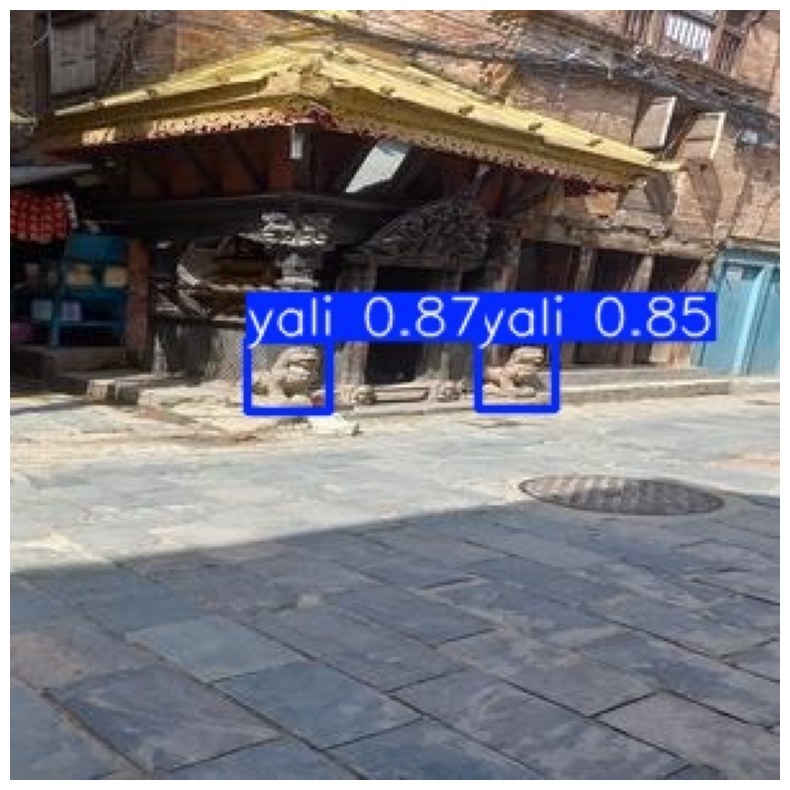

Processed /content/drive/MyDrive/VQA-Final/part A /YOLO/YOLO dataset /dataset-part-A/dataset-part-A/test/images/New_Yali_19_aug_0_jpg.rf.ddc069e786cedac3284a0d1f19656a20.jpg and saved result to /content/drive/MyDrive/VQA-Final/part A /YOLO/YOLO dataset /dataset-part-A/dataset-part-A/test/images/result.jpg


In [4]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Load the YOLO model
model = YOLO('/content/drive/MyDrive/VQA-Final/part A /YOLO/YOLO runs/detect/train/weights/best.pt')
test_folder = '/content/drive/MyDrive/VQA-Final/part A /YOLO/YOLO dataset /dataset-part-A/dataset-part-A/test/images'

# Get all image files in the folder
image_files = [os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select one image
random_image = random.choice(image_files)

# Process the selected image
results = model([random_image])  # Pass a list with a single image

# Save and display the result
result = results[0]  # Access the result for the single image
result_image_path = os.path.join(test_folder, "result.jpg")
result.save(filename=result_image_path)

# Load and display the result image
result_image = Image.open(result_image_path)
plt.figure(figsize=(10, 10))
plt.imshow(result_image)
# plt.title(f"Result for {os.path.basename(random_image)}")
plt.axis('off')
plt.show()

print(f"Processed {random_image} and saved result to {result_image_path}")

In [ ]:
print(model)

# BART #

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the tokenizer and model (make sure these paths match your setup)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
checkpoint_path = '/content/drive/MyDrive/VQA-Final/part B/Trained models/Bart_latest.pth'

# Load your trained model checkpoint
def load_checkpoint(model, file_path):
    checkpoint = torch.load(file_path, map_location=device)
    print('checkpoint keys: ', checkpoint.keys())
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded from {file_path}")

load_checkpoint(model, checkpoint_path)
model.eval()

In [7]:
# Function to generate answers based on input questions
def ask_question(question, object_name, max_length=80):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    combined_input = f"{object_name} {question}" if object_name else question

    inputs = tokenizer(
        combined_input,
        return_tensors="pt",
        max_length=128,
        truncation=True
    ).to(device)

    answer_ids = model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    answer = tokenizer.decode(answer_ids[0], skip_special_tokens=True)
    return answer

# Input to the BART Model

In [67]:
# Input your own question
user_input = input("Enter your question: ")
input_object = "Yali"

# Update the 'inputs' tuple to use the new variable name
inputs = f" {user_input}, {input_object} "
print("Input: ", inputs)

# Update this line to use the new variable name 'user_input'
input_tokens = tokenizer(inputs, return_tensors="pt").to(device)
tokens = tokenizer.convert_ids_to_tokens(input_tokens["input_ids"].squeeze().tolist())
print("\n--- Tokenization Results:  ---")
print(tokens)
print("\n--- Token_ids according to vocabulary: ---")
print(input_tokens)

Enter your question: What does Yali symbolize?
Input:   What does Yali symbolize?, Yali 

--- Tokenization Results:  ---
['<s>', 'ĠWhat', 'Ġdoes', 'ĠY', 'ali', 'Ġsymbol', 'ize', '?,', 'ĠY', 'ali', 'Ġ', '</s>']

--- Token_ids according to vocabulary: ---
{'input_ids': tensor([[    0,   653,   473,   854,  3644,  7648,  2072, 33647,   854,  3644,  1437,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


# Decoding Process of the BART model

In [69]:
with torch.no_grad():
    output = model.generate(**input_tokens, num_beams=5, max_length=100, early_stopping=True, output_attentions=True,
    output_hidden_states=True,
    return_dict_in_generate=True)

output.keys()
att_encoder = output.encoder_attentions
att_decoder = output.decoder_attentions
att_cross = output.cross_attentions

layer=5
print("cross attention: ", att_cross[layer][0].shape)
print("decoder attention: ", att_decoder[layer][0].shape)
print("encoder attention: ", att_encoder[layer].shape)

generated_tokens = output.sequences
output_tokens = tokenizer.convert_ids_to_tokens(generated_tokens.squeeze().tolist())
print("\n--- Tokens of Generated Answer: ---")
print(output_tokens)
generated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

print("\n--- Final Answer: ---")
print(f"Generated Answer : {generated_text}")


cross attention:  torch.Size([5, 12, 1, 12])
decoder attention:  torch.Size([5, 12, 1, 6])
encoder attention:  torch.Size([1, 12, 12, 12])

--- Tokens of Generated Answer: ---
['</s>', '<s>', 'y', 'ali', 'Ġsymbol', 'izes', 'Ġmortality', ',', 'Ġprotection', ',', 'Ġand', 'Ġvengeance', ',', 'Ġdepicted', 'Ġwith', 'Ġdog', '-', 'like', 'Ġcharacteristics', '.', '</s>']

--- Final Answer: ---
Generated Answer : yali symbolizes mortality, protection, and vengeance, depicted with dog-like characteristics.


In [ ]:
!pip install bertviz

In [ ]:
input_text =  "what does Yali symbolize?, Yali"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

with torch.no_grad():
    output = model.generate(**inputs, num_beams=5, max_length=100, early_stopping=True, output_attentions=True,
    output_hidden_states=True,
    return_dict_in_generate=True)

# Access the first generated sequence using output.sequences[0]
decoded_output = tokenizer.decode(output.sequences[0], skip_special_tokens=True)

print(f"Question: {input_text}")
print(f"Generated Answer : {decoded_output}")

output.keys()

In [60]:
generated_tokens = output.sequences
generated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

In [ ]:
generated_text

In [62]:
att_encoder = output.encoder_attentions
att_decoder = output.decoder_attentions
att_cross = output.cross_attentions

In [ ]:
layer = 5

print("cross attention: ", att_cross[layer][0].shape)
print("decoder attention: ", att_decoder[layer][0].shape)
print("encoder attention: ", att_encoder[layer].shape)

In [ ]:
att_decoder

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
print(tokens)

In [ ]:
output_tokens = tokenizer.convert_ids_to_tokens(generated_tokens.squeeze().tolist())
print(output_tokens)

In [66]:
from bertviz import head_view

encoder_input_ids = tokenizer(
    input_text,
    return_tensors="pt",
    add_special_tokens=True
).input_ids.to(device)

decoder_input_ids = tokenizer(
    generated_text,
    return_tensors="pt",
    add_special_tokens=True
).input_ids.to(device)


outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids, output_attentions=True)
encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

head_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens=encoder_text,
    decoder_tokens=decoder_text
)


<IPython.core.display.Javascript object>